# AUTHORS:


### Abhimanyu Borthakur (406530322)


### Lorenzo Bolls (505997448)


### Arthur Baghdasian (006001418)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from surprise import Reader, Dataset, accuracy
from surprise.prediction_algorithms.knns import KNNWithMeans
from surprise.model_selection import cross_validate, KFold, train_test_split
from sklearn.metrics import roc_curve, auc, mean_squared_error
from surprise.prediction_algorithms.matrix_factorization import NMF, SVD

# Question 1 (A)

In [2]:
dataset_folder = '../data/Synthetic_Movie_Lens/'
ratings_file = pd.read_csv(dataset_folder+"ratings.csv",usecols=['userId','movieId','rating']) 
user_ID = ratings_file.pop('userId').values
movie_ID = ratings_file.pop('movieId').values
rating = ratings_file.pop('rating').values
sparsity = len(rating)/(len(set(movie_ID))*len(set(user_ID)))
print(f'Sparsity = {sparsity}')

Sparsity = 0.016999683055613623


# Question 1 (B)

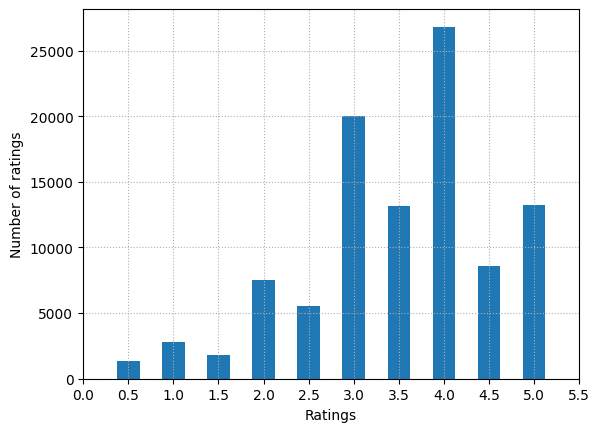

In [3]:
u, inv = np.unique(rating, return_inverse=True)
plt.bar(u, np.bincount(inv), width=0.25)
locs, labels = plt.xticks()  
plt.grid(linestyle=':')
plt.xticks(np.arange(0,6,0.5),rotation=0)
plt.ylabel('Number of ratings')
plt.xlabel('Ratings')
plt.savefig('../abhi_images/Q1B.png',dpi=300,bbox_inches='tight')
plt.show()

# Question 1 (C)

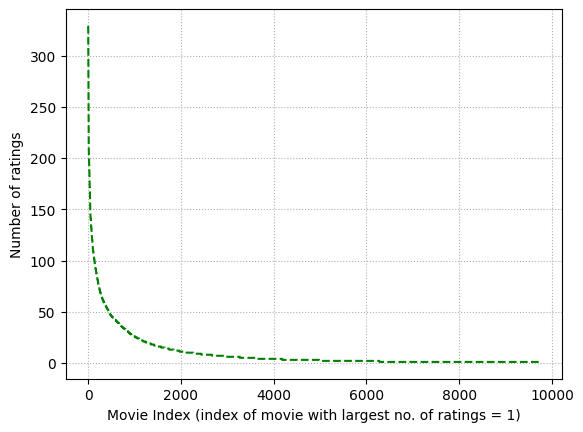

In [4]:
unique, counts = np.unique(movie_ID, return_counts=True)
plt.plot(range(1,len(unique)+1),counts[np.argsort(counts)[::-1]],linestyle='--',color='g')
plt.grid(linestyle=':')
plt.ylabel('Number of ratings')
plt.xlabel('Movie Index (index of movie with largest no. of ratings = 1)')
plt.savefig('../abhi_images/Q1C.png',dpi=300,bbox_inches='tight')
plt.show()

In [7]:
movie_count_dict = {} 
x = list(range(1,len(unique)+1))
for key in unique[np.argsort(counts)[::-1]]: 
    for value in x: 
        movie_count_dict[key] = value 
        x.remove(value) 
        break 
print('Top 5 rated movies (Movie ID, Index):')
print(list(movie_count_dict.items())[0:5])

Top 5 rated movies (Movie ID, Index):
[(356, 1), (318, 2), (296, 3), (593, 4), (2571, 5)]


# Question 1 (D)

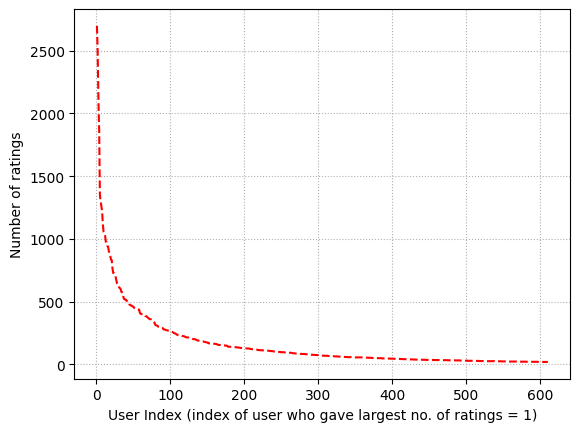

In [9]:
unique, counts = np.unique(user_ID, return_counts=True)
plt.plot(range(1,len(unique)+1),counts[np.argsort(counts)[::-1]],linestyle='--',color='r')
plt.grid(linestyle=':')
plt.ylabel('Number of ratings')
plt.xlabel('User Index (index of user who gave largest no. of ratings = 1)')
plt.savefig('../abhi_images/Q1D.png',dpi=300,bbox_inches='tight')
plt.show()

In [10]:
user_count_dict = {} 
x = list(range(1,len(unique)+1))
for key in unique[np.argsort(counts)[::-1]]: 
    for value in x: 
        user_count_dict[key] = value 
        x.remove(value) 
        break 
print('Top 5 users who rated most number of times (User ID, Index):')
print(list(user_count_dict.items())[0:5])

Top 5 users who rated most number of times (User ID, Index):
[(414, 1), (599, 2), (474, 3), (448, 4), (274, 5)]


# Question 1 (E)

# Question 1 (F)

In [11]:
unique_movie_ID = list(set(movie_ID))
movie_ID_list = []
var_list = []
for j in range(len(unique_movie_ID)):
    indices = [i for i, x in enumerate(movie_ID) if x == unique_movie_ID[j]]
    var = np.var(np.array(rating[indices]))
    movie_ID_list.append(unique_movie_ID[j])
    var_list.append(var)

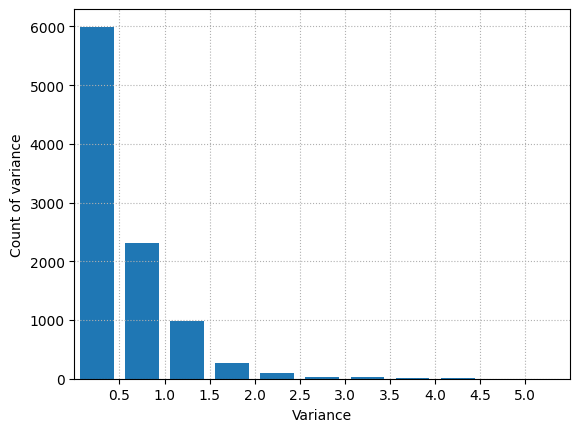

In [12]:
plt.hist(var_list, bins=np.arange(0,5.5,0.5),rwidth=0.75)
plt.xticks(np.arange(0.5,5.5,0.5))
plt.xlim([0, 5.5])
plt.grid(linestyle=':')
plt.xlabel('Variance')
plt.ylabel('Count of variance')
plt.savefig('../abhi_images/Q1F.png',dpi=300,bbox_inches='tight')
plt.show()

# Question 2

# Question 3

# Question 4

In [18]:
df = pd.read_csv('../data/Synthetic_Movie_Lens/ratings.csv', index_col=0)
df = df.reset_index(drop=True)  # If the first column was just the old index
df.to_csv('../data/Synthetic_Movie_Lens/ratings_fixed.csv', index=False)
df.head()

,userId,movieId,rating,timestamp
0,496,112852,3.0,1415520462
1,391,1947,4.0,1030945141
2,387,1562,1.5,1095041022
3,474,2716,4.5,1053020930
4,483,88125,4.5,1311337237


In [19]:
reader = Reader(line_format='user item rating timestamp',sep=',',rating_scale=(0.5, 5),skip_lines=1)
ratings_dataset = Dataset.load_from_file(dataset_folder+"ratings_fixed.csv",reader=reader)

In [20]:
k = np.arange(2,102,2)
rmse = []
mae = []
for item in k:
    print('Testing for k =',item)
    res = cross_validate(KNNWithMeans(k=item,sim_options={'name':'pearson', 'user_based': True}),
                         measures=['rmse','mae'],data = ratings_dataset,cv=10,n_jobs=-1)   
    rmse.append(np.mean(res['test_rmse']))
    mae.append(np.mean(res['test_mae']))

Testing for k = 2
Testing for k = 4
Testing for k = 6
Testing for k = 8
Testing for k = 10
Testing for k = 12
Testing for k = 14
Testing for k = 16
Testing for k = 18
Testing for k = 20
Testing for k = 22
Testing for k = 24
Testing for k = 26
Testing for k = 28
Testing for k = 30
Testing for k = 32
Testing for k = 34
Testing for k = 36
Testing for k = 38
Testing for k = 40
Testing for k = 42
Testing for k = 44
Testing for k = 46
Testing for k = 48
Testing for k = 50
Testing for k = 52
Testing for k = 54
Testing for k = 56
Testing for k = 58
Testing for k = 60
Testing for k = 62
Testing for k = 64
Testing for k = 66
Testing for k = 68
Testing for k = 70
Testing for k = 72
Testing for k = 74
Testing for k = 76
Testing for k = 78
Testing for k = 80
Testing for k = 82
Testing for k = 84
Testing for k = 86
Testing for k = 88
Testing for k = 90
Testing for k = 92
Testing for k = 94
Testing for k = 96
Testing for k = 98
Testing for k = 100


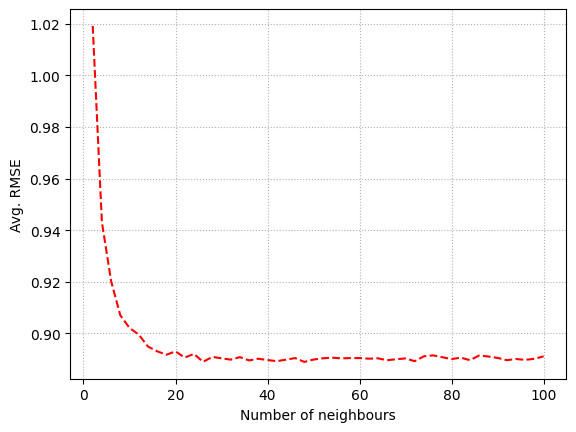

In [21]:
plt.plot(k,rmse,linestyle='--',color='r')
plt.grid(linestyle=':')
plt.ylabel('Avg. RMSE')
plt.xlabel('Number of neighbours')
plt.savefig('../abhi_images/Q4A.png',dpi=300,bbox_inches='tight')
plt.show()

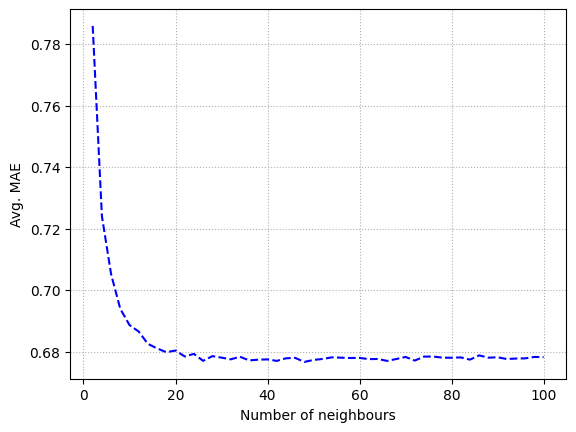

In [22]:
plt.plot(k,mae,linestyle='--',color='b')
plt.grid(linestyle=':')
plt.ylabel('Avg. MAE')
plt.xlabel('Number of neighbours')
plt.savefig('../abhi_images/Q4B.png',dpi=300,bbox_inches='tight')
plt.show()

# Question 5

# Question 6

=== Popular Subset ===
Best k: 42, Min Avg RMSE: 0.8702


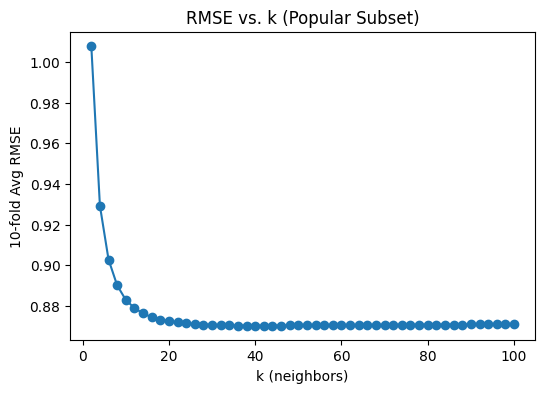

=== Unpopular Subset ===
Best k: 2, Min Avg RMSE: 1.0637


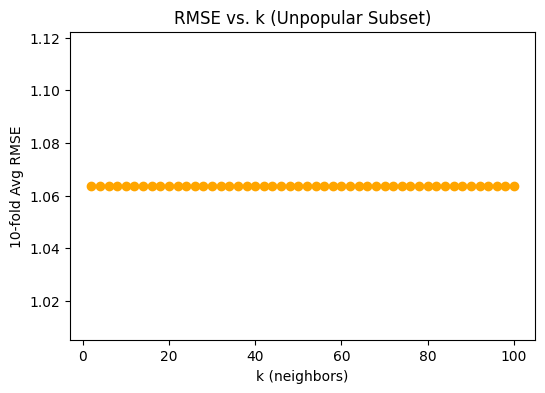

=== High-Variance Subset ===
Best k: 2, Min Avg RMSE: 1.5038


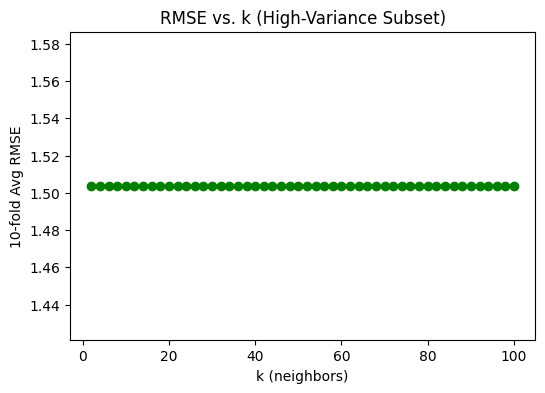

In [26]:
from collections import defaultdict

def trim_data(raw_data, method='popular', rating_threshold=2, var_threshold=2.0, min_var_count=5):
    item_ratings = defaultdict(list)
    for (u, i, r, t) in raw_data:
        item_ratings[i].append(r)
    if method == 'popular':
        keep_items = {i for i, rlist in item_ratings.items() if len(rlist) > rating_threshold}
    elif method == 'unpopular':
        keep_items = {i for i, rlist in item_ratings.items() if len(rlist) <= rating_threshold}
    elif method == 'high_variance':
        keep_items = []
        for i, rlist in item_ratings.items():
            if len(rlist) >= min_var_count:
                if np.var(rlist) >= var_threshold:
                    keep_items.append(i)
        keep_items = set(keep_items)
    else:
        raise ValueError("method must be 'popular', 'unpopular', or 'high_variance'")
    trimmed = [(u, i, r, t) for (u, i, r, t) in raw_data if i in keep_items]
    return trimmed

def evaluate_knn_for_subset(trimmed_raw_data, k_values, user_based=True):
    df = pd.DataFrame(trimmed_raw_data, columns=['userID','itemID','rating','timestamp'])
    reader = Reader(rating_scale=(0.5, 5))
    data = Dataset.load_from_df(df[['userID','itemID','rating']], reader)
    kf = KFold(n_splits=10, random_state=0, shuffle=True)
    rmse_results = []
    for k in k_values:
        fold_rmse = []
        for trainset, testset in kf.split(data):
            algo = KNNWithMeans(k=k, sim_options={'name': 'pearson','user_based': user_based}, verbose=False)
            algo.fit(trainset)
            predictions = algo.test(testset)
            fold_rmse.append(accuracy.rmse(predictions, verbose=False))
        rmse_results.append(np.mean(fold_rmse))
    return rmse_results

full_data_raw = ratings_dataset.raw_ratings
popular_data_raw = trim_data(full_data_raw, method='popular', rating_threshold=2)
unpopular_data_raw = trim_data(full_data_raw, method='unpopular', rating_threshold=2)
high_var_data_raw = trim_data(full_data_raw, method='high_variance', var_threshold=2.0, min_var_count=5)
k_values = list(range(2, 101, 2))
rmse_popular = evaluate_knn_for_subset(popular_data_raw, k_values, user_based=True)
best_k_popular = k_values[np.argmin(rmse_popular)]
best_rmse_popular = min(rmse_popular)
print("=== Popular Subset ===")
print(f"Best k: {best_k_popular}, Min Avg RMSE: {best_rmse_popular:.4f}")
plt.figure(figsize=(6,4))
plt.plot(k_values, rmse_popular, marker='o')
plt.title("RMSE vs. k (Popular Subset)")
plt.xlabel("k (neighbors)")
plt.ylabel("10-fold Avg RMSE")
plt.show()
rmse_unpopular = evaluate_knn_for_subset(unpopular_data_raw, k_values, user_based=True)
best_k_unpopular = k_values[np.argmin(rmse_unpopular)]
best_rmse_unpopular = min(rmse_unpopular)
print("=== Unpopular Subset ===")
print(f"Best k: {best_k_unpopular}, Min Avg RMSE: {best_rmse_unpopular:.4f}")
plt.figure(figsize=(6,4))
plt.plot(k_values, rmse_unpopular, marker='o', color='orange')
plt.title("RMSE vs. k (Unpopular Subset)")
plt.xlabel("k (neighbors)")
plt.ylabel("10-fold Avg RMSE")
plt.show()
rmse_highvar = evaluate_knn_for_subset(high_var_data_raw, k_values, user_based=True)
best_k_highvar = k_values[np.argmin(rmse_highvar)]
best_rmse_highvar = min(rmse_highvar)
print("=== High-Variance Subset ===")
print(f"Best k: {best_k_highvar}, Min Avg RMSE: {best_rmse_highvar:.4f}")
plt.figure(figsize=(6,4))
plt.plot(k_values, rmse_highvar, marker='o', color='green')
plt.title("RMSE vs. k (High-Variance Subset)")
plt.xlabel("k (neighbors)")
plt.ylabel("10-fold Avg RMSE")
plt.show()

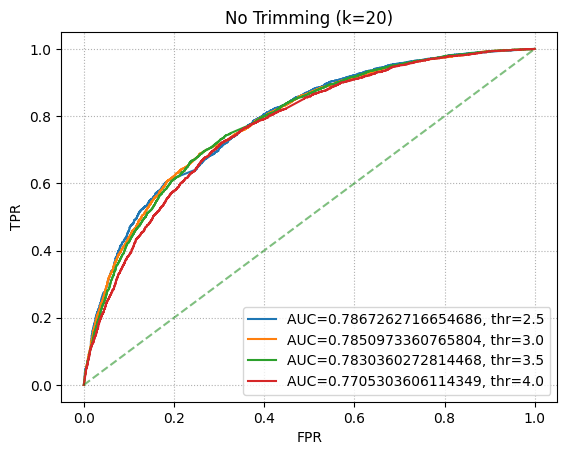

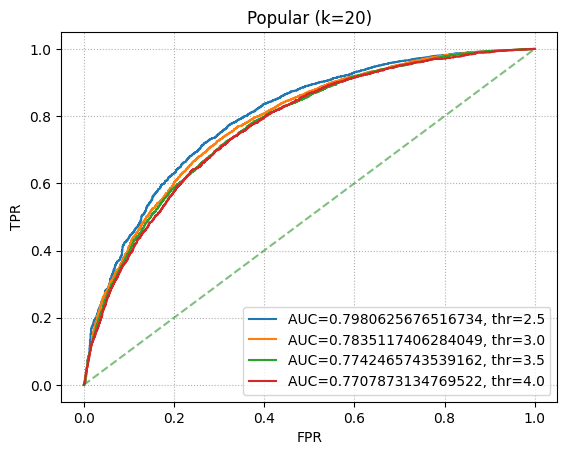

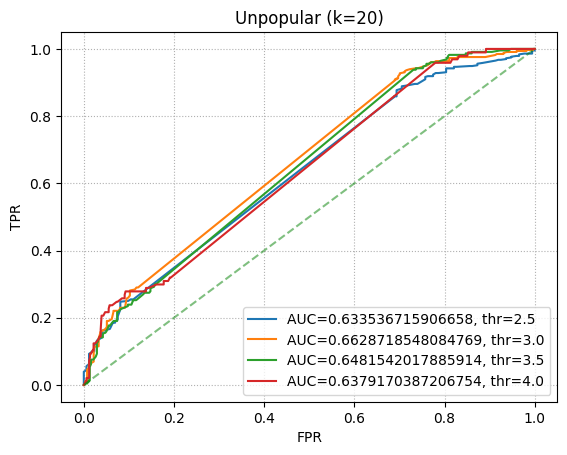

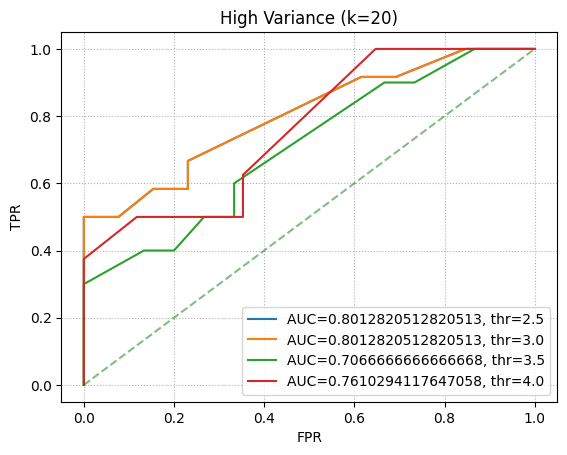

In [27]:
thres=[2.5,3.0,3.5,4.0]
raw_full=ratings_dataset.raw_ratings
df_full=pd.DataFrame(raw_full,columns=['u','i','r','t'])
reader=Reader(rating_scale=(0.5,5))
data_full=Dataset.load_from_df(df_full[['u','i','r']],reader)
trainf,testf=train_test_split(data_full,test_size=0.1)
algof=KNNWithMeans(k=20,sim_options={'name':'pearson'},verbose=False).fit(trainf)
resf=algof.test(testf)
fig,ax=plt.subplots()
for x in thres:
    y=[1 if row.r_ui>x else 0 for row in resf]
    fpr,tpr,_=roc_curve(y,[row.est for row in resf])
    ax.plot(fpr,tpr,label="AUC="+str(auc(fpr,tpr))+", thr="+str(x))
ax.plot([0,1],[0,1],'--',color='g',alpha=.5)
plt.legend(loc='best')
plt.grid(linestyle=':')
plt.title('No Trimming (k=20)')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

raw_pop=trim_data(raw_full,'popular',2)
df_pop=pd.DataFrame(raw_pop,columns=['u','i','r','t'])
data_pop=Dataset.load_from_df(df_pop[['u','i','r']],reader)
trainp,testp=train_test_split(data_pop,test_size=0.1)
algop=KNNWithMeans(k=20,sim_options={'name':'pearson'},verbose=False).fit(trainp)
resp=algop.test(testp)
fig,ax=plt.subplots()
for x in thres:
    y=[1 if row.r_ui>x else 0 for row in resp]
    fpr,tpr,_=roc_curve(y,[row.est for row in resp])
    ax.plot(fpr,tpr,label="AUC="+str(auc(fpr,tpr))+", thr="+str(x))
ax.plot([0,1],[0,1],'--',color='g',alpha=.5)
plt.legend(loc='best')
plt.grid(linestyle=':')
plt.title('Popular (k=20)')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

raw_unp=trim_data(raw_full,'unpopular',2)
df_unp=pd.DataFrame(raw_unp,columns=['u','i','r','t'])
data_unp=Dataset.load_from_df(df_unp[['u','i','r']],reader)
trainu,testu=train_test_split(data_unp,test_size=0.1)
algou=KNNWithMeans(k=20,sim_options={'name':'pearson'},verbose=False).fit(trainu)
resu=algou.test(testu)
fig,ax=plt.subplots()
for x in thres:
    y=[1 if row.r_ui>x else 0 for row in resu]
    fpr,tpr,_=roc_curve(y,[row.est for row in resu])
    ax.plot(fpr,tpr,label="AUC="+str(auc(fpr,tpr))+", thr="+str(x))
ax.plot([0,1],[0,1],'--',color='g',alpha=.5)
plt.legend(loc='best')
plt.grid(linestyle=':')
plt.title('Unpopular (k=20)')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

raw_hv=trim_data(raw_full,'high_variance',2,2.0,5)
df_hv=pd.DataFrame(raw_hv,columns=['u','i','r','t'])
data_hv=Dataset.load_from_df(df_hv[['u','i','r']],reader)
trainh,testh=train_test_split(data_hv,test_size=0.1)
algoh=KNNWithMeans(k=20,sim_options={'name':'pearson'},verbose=False).fit(trainh)
resh=algoh.test(testh)
fig,ax=plt.subplots()
for x in thres:
    y=[1 if row.r_ui>x else 0 for row in resh]
    fpr,tpr,_=roc_curve(y,[row.est for row in resh])
    ax.plot(fpr,tpr,label="AUC="+str(auc(fpr,tpr))+", thr="+str(x))
ax.plot([0,1],[0,1],'--',color='g',alpha=.5)
plt.legend(loc='best')
plt.grid(linestyle=':')
plt.title('High Variance (k=20)')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

# Question 7